# Goals
*   Scale data and unscale (robust scaler)
*   Make GAN better (wgan,cgan, change activation function to linear, increase model capacity, play with learning rate)
*   Create own LSTM layer



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import datetime
import pickle
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LayerNormalization, Dropout, Normalization
from tensorflow.keras import layers, models, optimizers
import keras
from keras import ops
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler,RobustScaler

# Data Generation

In [2]:
def download_data(ticker_symbol,start_date,end_date):
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    data.index = data.index.date
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    data["tomorrow_close_price"] = data["Close"].shift(-1)
    data = data.dropna(subset=["tomorrow_close_price"])

    return data

In [3]:
def create_windows(data,window_size):
    dataframes_list = []

    for i in range(data.shape[0]-100):
      window = data[i+1:i+101]
      dataframes_list.append(window)

    return dataframes_list

In [8]:
start_date = "1994-01-03"
end_date = "2024-11-15"
ticker_symbol = 'AAPL'
window_size = 100

data = download_data(ticker_symbol=ticker_symbol,start_date=start_date,end_date=end_date)
target = data['tomorrow_close_price']
target = target[100:]
data.drop(columns=['tomorrow_close_price'],inplace=True)
dataframes_list = create_windows(data=data,window_size=window_size)

x_train,y_train = dataframes_list[:-30],target[:-30]
x_test,y_test = dataframes_list[-30:],target[-30:]
assert len(x_train)==len(y_train)
assert len(x_test)==len(y_test)
x_train,x_test = np.array([df.values for df in x_train]),np.array([df.values for df in x_test])

[*********************100%***********************]  1 of 1 completed


In [10]:
scaler_X = RobustScaler()
scaler_y = RobustScaler()

# Scale features
num_train_samples, window_size, num_features = x_train.shape
num_test_samples = x_test.shape[0]

x_train_reshaped = x_train.reshape(-1, num_features)
x_test_reshaped = x_test.reshape(-1, num_features)

scaler_X.fit(x_train_reshaped)

x_train_scaled = scaler_X.transform(x_train_reshaped).reshape(num_train_samples, window_size, num_features)
x_test_scaled = scaler_X.transform(x_test_reshaped).reshape(num_test_samples, window_size, num_features)

# Scale targets
y_train_reshaped = y_train.to_numpy().reshape(-1, 1)
y_test_reshaped = y_test.to_numpy().reshape(-1, 1)

scaler_y.fit(y_train_reshaped)

y_train_scaled = scaler_y.transform(y_train_reshaped).flatten()
y_test_scaled = scaler_y.transform(y_test_reshaped).flatten()

# Now x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled are ready for model training

# Example of unscaling predictions
# Suppose y_pred_scaled is obtained from your model
# y_pred_scaled = model.predict(x_test_scaled)
# y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

In [14]:
x_train,x_test,y_train,y_test = x_train_scaled,x_test_scaled,y_train_scaled,y_test_scaled

# LSTM Model

In [37]:
normalization_layer = Normalization()
def create_normalization_layer(x_train):
    num_samples, timesteps, num_features = x_train.shape #num_samples, timesteps, num_features
    x_train_flat = x_train.reshape(-1, num_features)
    normalization_layer.adapt(x_train_flat)

def build_model(timesteps,features):
    model = Sequential([
        keras.Input(shape=(timesteps, features)),
        normalization_layer,
        LSTM(256, return_sequences=True),
        LSTM(256, return_sequences=True),
        LSTM(256),
        Dense(1, activation='linear')  # Example output layer
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error','mean_squared_error'])
    model.summary()

    return model

In [35]:
import matplotlib.pyplot as plt

def plot_model(history):
    # Extract metrics from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']

    mse = history.history['mean_squared_error']
    val_mse = history.history['val_mean_squared_error']

    epochs_range = range(1, epochs + 1)

    # Create subplots
    plt.figure(figsize=(21, 5))  # Increased width for better spacing

    # Plot Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, loss, label='Training Loss (MSE)')
    plt.plot(epochs_range, val_loss, label='Validation Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # Plot Training and Validation MAE
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, mae, label='Training MAE')
    plt.plot(epochs_range, val_mae, label='Validation MAE')
    plt.title('Training and Validation Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Plot Training and Validation MSE
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, mse, label='Training MSE')
    plt.plot(epochs_range, val_mse, label='Validation MSE')
    plt.title('Training and Validation Mean Squared Error')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

def plot_predictions(model, x_test, y_test):
    """
    Plots predicted vs. actual stock prices.

    Parameters:
    - model (tf.keras.Model): Trained Keras model.
    - x_test (np.array): Test input data.
    - y_test (np.array): Actual stock prices.
    """
    # Make predictions and scaler inverse it
    predictions = model.predict(x_test)
    predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
      # Convert y_test to NumPy array if it's a pandas Series
    if isinstance(y_test, pd.Series):
        actual = y_test.to_numpy().flatten()
    else:
        actual = y_test.flatten()
    actual = scaler_y.inverse_transform(actual.reshape(-1,1)) #Inverse transform target

    # Scatter Plot: Predictions vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predictions, alpha=0.5, label='Predictions')
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', label='Perfect Prediction')
    plt.title('Predicted vs Actual Stock Prices')
    plt.xlabel('Actual Stock Price')
    plt.ylabel('Predicted Stock Price')
    plt.legend()
    plt.show()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 100, 256)            │         269,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 100, 256)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320,193 (5.04 MB)

 Trainable params: 1,320,193 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0445 - mean_absolute_error: 0.0445 - mean_squared_error: 0.0094 - val_loss: 1.3263 - val_mean_absolute_error: 1.3263 - val_mean_squared_error: 2.7692
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - mean_squared_error: 7.7956e-04 - val_loss: 0.9985 - val_mean_absolute_error: 0.9985 - val_mean_squared_error: 1.6937
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0181 - mean_absolute_error: 0.0181 - mean_squared_error: 8.6595e-04 - val_loss: 1.2965 - val_mean_absolute_error: 1.2965 - val_mean_squared_error: 2.5626
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - mean_squared_error: 0.0013 - val_loss: 1.2159 - val_mean_absolute_error: 1.2159 - val_mean_squared_error: 2.4079
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0145 - mean_absolute_error: 0.0145 - mean_squared_error: 5.7573e-04 - val_los

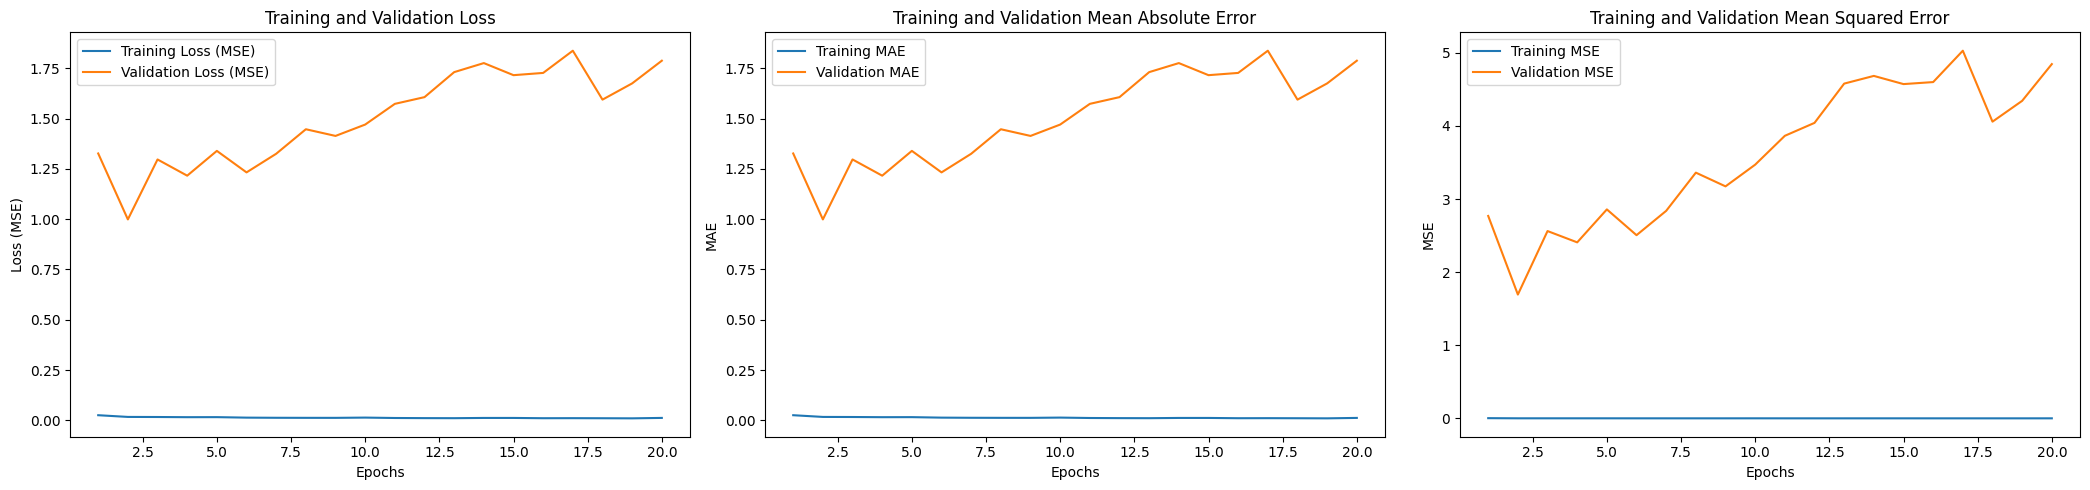

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


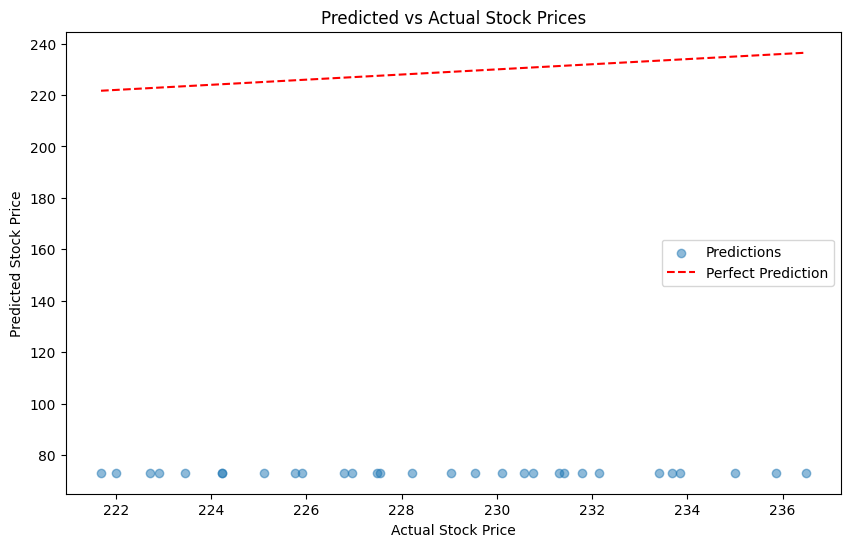

In [36]:
timesteps = 100
features = 6 #Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
epochs = 20

create_normalization_layer(x_train)
model = build_model(timesteps=timesteps,features=features)
history = model.fit(x_train,y_train,epochs=epochs,validation_split=0.2)
model.evaluate(x_test,y_test)

plot_model(history)
plot_predictions(model, x_test, y_test)

# GAN

In [17]:
gan_train = np.hstack((x_train.reshape(x_train.shape[0], -1), y_train.reshape(-1, 1)))

In [18]:
print("gan_train shape:", gan_train.shape)  # Should print (num_samples, 601)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

gan_train shape: (7642, 601)
x_train shape: (7642, 100, 6)
y_train shape: (7642,)


In [19]:
latent_dim = 100
output_dim = 601 #6 columns * 100 rows + tomorrow's close price
batch_size = 64

generator = Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Reshape((latent_dim, 1)), #Change noise vector to 3d
    layers.LSTM(256,return_sequences=True),
    layers.LSTM(256),
    layers.Dense(output_dim, activation='tanh'),
    layers.Reshape((output_dim, 1))  # Reshape to (601, 1)
],name="generator",)

discriminator = Sequential([
    keras.Input(shape=(output_dim, 1)),  # Input shape: (601, 1)
    layers.LSTM(256,return_sequences=True),
    layers.LSTM(256,return_sequences=False),
    layers.Dense(1,activation='sigmoid')
],name='discriminator')
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

In [20]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, batch_size):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.seed_generator = keras.random.SeedGenerator(2004)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
         return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, dataset):
        #Dynamically determine batch_size, because the last batch /= batch_size due to not enough samples
        #This is a symbolic tensor, so can't use np.random.normal but tf.random.normal
        batch_size = tf.shape(dataset)[0]
        #Generate real samples
        real_samples = tf.reshape(dataset, (batch_size, 601, 1))
        #Generate fake samples
        noise = tf.random.normal(shape=(batch_size, self.latent_dim), mean=0.0, stddev=1.0)
        generated_samples = self.generator(noise)

        #Combine labels and samples. 1 means fake, 0 means real. Total 128 of 601 vectors
        labels = tf.concat([
            tf.zeros((batch_size, 1)),  # Fake labels
            tf.ones((batch_size, 1))    # Real labels
        ], axis=0)
        combined_samples = tf.concat([generated_samples, real_samples], axis=0)


        # Train the discriminator
        with tf.GradientTape() as tape:
            self.discriminator.trainable = True
            predictions = self.discriminator(combined_samples)
            d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

        #Generate fake labels
        misleading_labels = tf.ones((batch_size, 1))
        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            self.discriminator.trainable = False
            predictions = self.discriminator(self.generator(noise))
            g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_dataframes=3, latent_dim=100):
        self.num_dataframes = num_dataframes
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)
        self.window_size = 100
        self.num_features = 6

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0 or epoch == 1:
            noise = np.random.normal(0, 1, (self.num_dataframes, self.latent_dim))
            generated_samples = self.model.generator(noise, training=False)
            for i in range(self.num_dataframes):
                sample_flat = generated_samples[i].numpy().reshape(-1)  # Shape: (601,)
                window_data = sample_flat[:-1]  # First 600 elements
                target = sample_flat[-1]        # Last element
                window_reshaped = window_data.reshape(self.window_size, self.num_features)
                df_generated = pd.DataFrame(window_reshaped, columns=['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'])
                print(df_generated.head())
                print(f"Tomorrow's Close Price: {target:.2f}")

In [21]:
epochs = 10000  # In practice, use ~100 epochs
latent_dim = 100
output_dim = 601 #6 columns * 100 rows + tomorrow's close price
batch_size = 64
num_dataframes = 3

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim,batch_size=batch_size)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(gan_train, epochs=epochs,batch_size=64,callbacks=[GANMonitor(num_dataframes=num_dataframes, latent_dim=latent_dim)])

Epoch 1/10000
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - d_loss: 0.7536 - g_loss: 0.7733   Adj Close     Close      High       Low      Open    Volume
0   0.312018 -0.601868  0.210721  0.396295 -0.289603 -0.224724
1   0.229569 -0.236021  0.266879  0.097553  0.034113 -0.300914
2   0.059057 -0.318617  0.728276  0.162938  0.195273 -0.207680
3  -0.199140  0.419703  0.287711  0.558552  0.332560 -0.011380
4  -0.248833  0.130569 -0.011702  0.434288 -0.046710  0.308102
Tomorrow's Close Price: -0.80
   Adj Close     Close      High       Low      Open    Volume
0   0.312606 -0.602500  0.210489  0.395882 -0.289819 -0.224634
1   0.228661 -0.235254  0.267115  0.097351  0.033919 -0.300900
2   0.059484 -0.318278  0.727804  0.162412  0.195582 -0.207576
3  -0.199398  0.419950  0.287828  0.558714  0.333047 -0.010356
4  -0.248629  0.130507 -0.011952  0.434522 -0.047530  0.307006
Tomorrow's Close Price: -0.80
   Adj Close     Close      High       Low      Open    Volume
0   0.313695 -0.601385  0.21103

KeyboardInterrupt: 